# SAYCam dataset processing



Chris Iyer

updated 11/19/24

In [7]:
import os, glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import seaborn as sns
import statsmodels.api as sm
sns.set(style='white', palette='colorblind', context='talk')

## Preprocessing & loading videos

In [143]:
# helper for below to preprocess images

def crop_frame(frame, square_len = 420, vertical_offset = 30):
    """
    This function takes in a frame and crops it. It also fixes the flipped orientation. It also converts BRG format to RGB.
    This has two purposes: crop out the timestamp, and just to focus on the center of the frame.
    Inputs:
        - frame to crop (originally, the images are height 480 and width 640)
        - square_len: the side length (px) of a centered square to crop
        - offset: the distance (px) to move the square from centered
    Outputs: the cropped frame
    """
    # STEP 1: FLIP THE IMAGE (they come flipped, I don't know why)
    frame = frame[::-1, ::-1, :]

    # STEP 2: get the coordinates boudning the square
    frame_height, frame_width = frame.shape[:2]
    center_x, center_y = frame_width // 2, frame_height // 2
    adjusted_center_y = center_y + vertical_offset
    start_x = max(center_x - square_len // 2, 0) 
    start_y = max(adjusted_center_y - square_len // 2, 0)
    end_x = min(start_x + square_len, frame_width)
    end_y = min(start_y + square_len, frame_height)
    
    # STEP 3: crop
    cropped_frame = frame[start_y:end_y, start_x:end_x, :]

    # STEP 4: flip BGR to RGB
    cropped_frame = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB) 
    return cropped_frame


def get_video_info(cap):
    """Returns video information"""
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_rate = cap.get(cv2.CAP_PROP_FPS)  # leave this as a float
    frame_length = frame_count // frame_rate
    return frame_count, frame_width, frame_height, frame_rate, frame_length

In [47]:
### CURRENTLY UNUSED (distortion correction)

def undistort_fisheye_frame(frame, camera_matrix=None, dist_coeffs=None):
    """
    NOT CURRENTLY USED!
    Uses built-in CV2 functionality to undistort the frame
    """
    if camera_matrix is None or dist_coeffs is None: # Default calibration values (assumed general fisheye characteristics)
        h, w = frame.shape[:2]
        focal_length = max(w, h) / 2
        camera_matrix = np.array([
            [focal_length, 0, w / 2],
            [0, focal_length, h / 2],
            [0, 0, 1]
        ])
        dist_coeffs = np.array([-0.3, 0.1, 0, 0])  # Approximate fisheye distortion coefficients
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(
        camera_matrix, dist_coeffs, np.eye(3), camera_matrix, frame.shape[:2][::-1], cv2.CV_16SC2
    )
    undistorted_frame = cv2.remap(frame, map1, map2, interpolation=cv2.INTER_LINEAR)
    return undistorted_frame

def preprocess_frame(frame, distortion_correction=True, crop=True):
    """
    Preprocesses an individual frame, with the following steps:
        1) changes default BGR to RGB
        2) undistorts the fisheye with function above
        3) crops off the times
    """
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # RGB instead of default
    if distortion_correction:
        frame = undistort_fisheye_frame(frame)
    if crop:
        frame = crop_frame(frame)
    return frame

In [144]:
def load_video(video_path, n_frames=None, downsampled_frame_rate=None, crop=True):
    """
    Loads a video to np.array.
    - n_frames specifies how many frames to load (if not supplied, loads all target frames).
    - downsampled_frame_rate specifies how many frames per second (Hz) to sample.
    - cropping is performed by the helper function crop_frame.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []

    original_frame_rate = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video_duration = total_frames / original_frame_rate

    if downsampled_frame_rate:
        # print(f'Original framerate: {original_frame_rate:.2f} Hz, downsampling to {downsampled_frame_rate} Hz.')
        # Generate target timestamps at the downsampled frame rate
        target_times = np.arange(0, video_duration, 1 / downsampled_frame_rate)
    else:
        target_times = np.arange(total_frames) / original_frame_rate

    if n_frames:
        target_times = target_times[:n_frames]  # Limit to n_frames if specified

    for target_time in target_times:
        cap.set(cv2.CAP_PROP_POS_MSEC, target_time * 1000) # Set the capture position to the desired timestamp (in milliseconds)
        ret, frame = cap.read()
        if not ret: # done with the video
            break
        if crop:
            frame = crop_frame(frame)
        frames.append(frame)
    
    cap.release()
    return np.array(frames)

In [125]:
def plot_frame(frame, title=''):
    plt.imshow(frame)
    plt.suptitle(title)
    plt.axis('off')  
    plt.show()

def plot_frames(images, titles=None):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        if titles is not None:
            ax.set_title(titles[i])
        ax.axis('off')  # Hide axes for a cleaner look
    plt.tight_layout()
    plt.show()

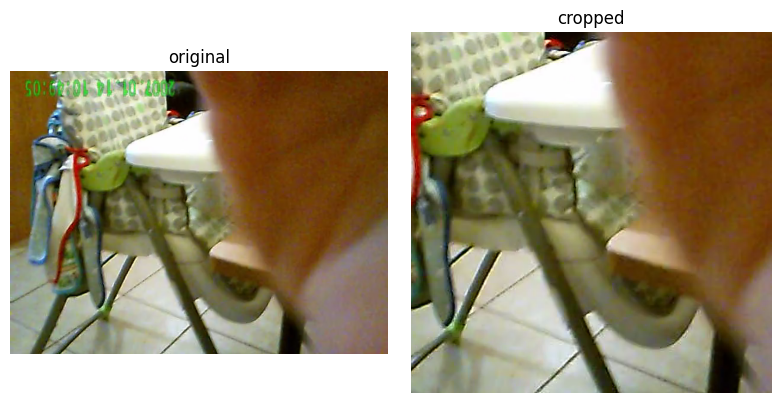

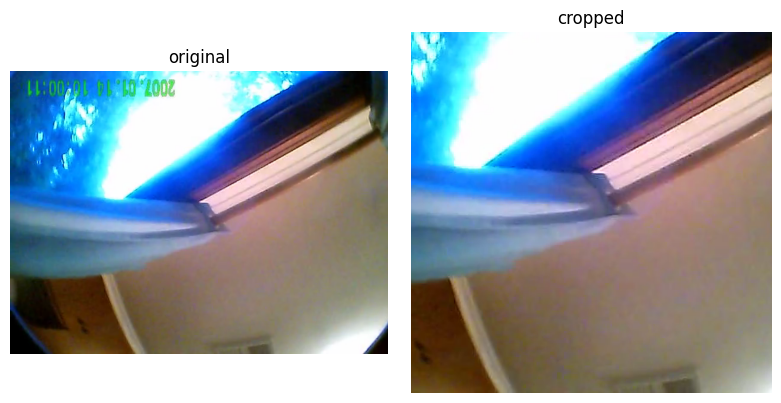

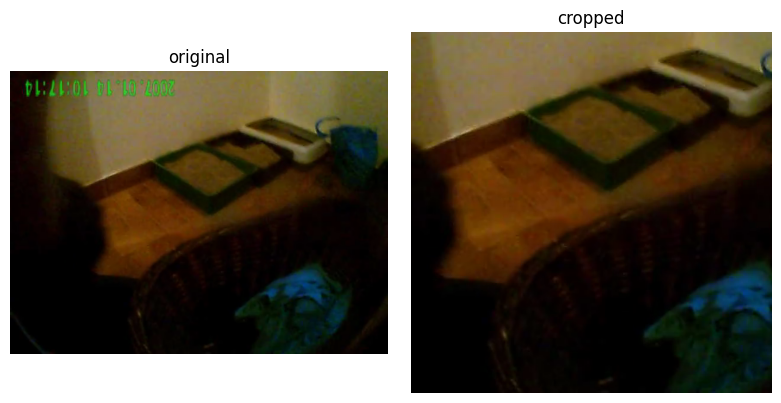

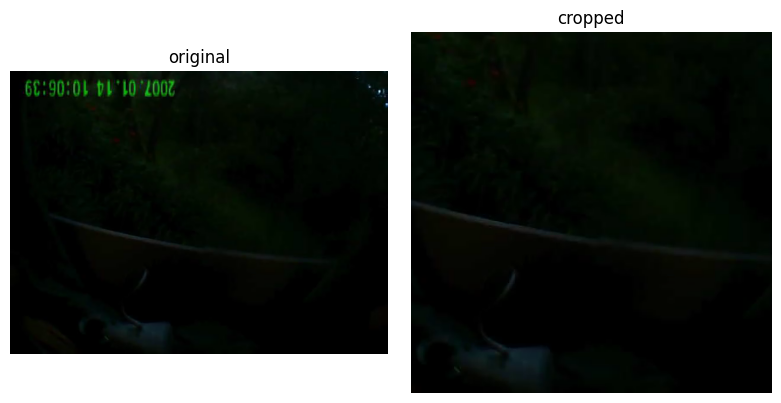

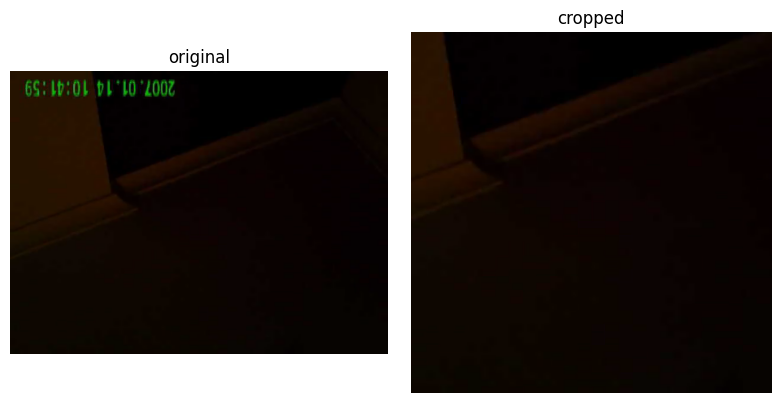

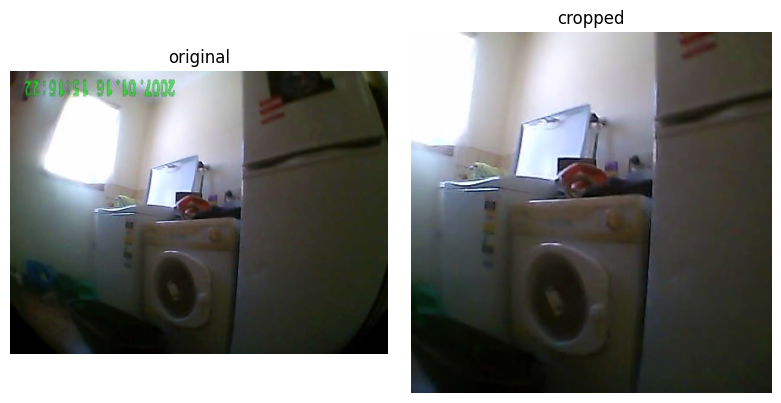

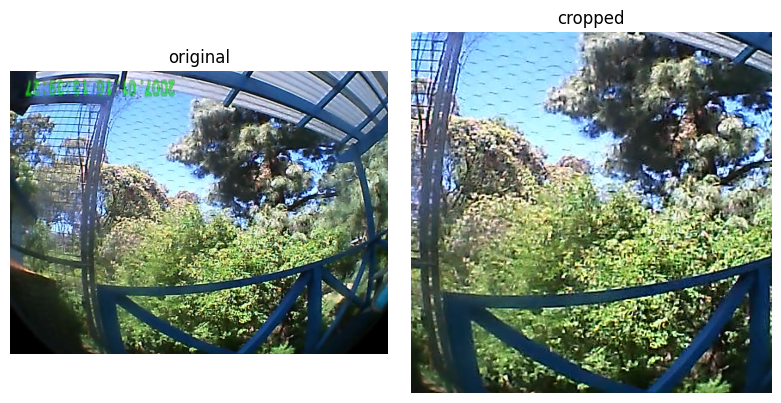

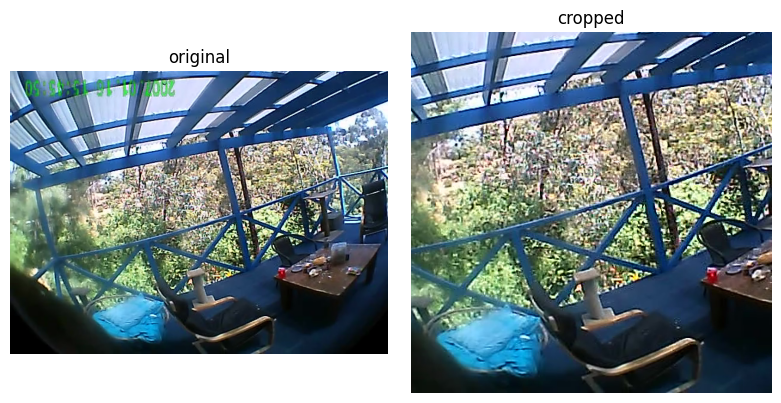

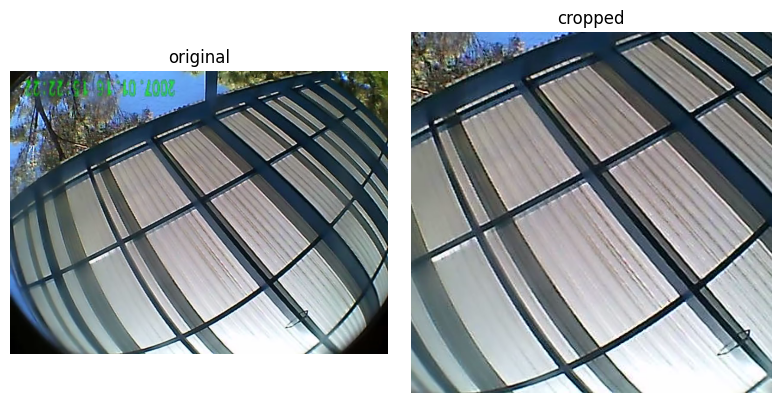

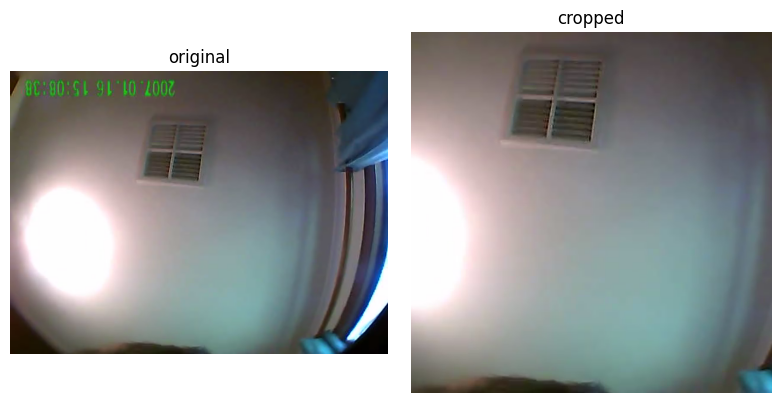

In [133]:
# See example frames and the different preprocessing steps
video_paths = glob.glob('33*/*.mp4')

for video in video_paths:
    frame1 = load_video(video, n_frames=2, crop=False)[1] # gets the second frame
    frame2 = crop_frame(frame1)
    plot_frames([cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)[::-1,::-1,:] , frame2], ['original', 'cropped'])

# video = video_paths[-1]
# frame = load_video(video, n_frames=1, downsampled_frame_rate=1)[0] # downsample to 3 Hz
# plot_frame(frame, title=video)

## Model embedding

Google vision transformer https://huggingface.co/google/vit-base-patch16-224-in21k

In [134]:
from transformers import ViTImageProcessor, ViTModel
import torch

/Users/chrisiyer/miniconda3/envs/saycam/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [149]:
def load_model():
    """
    Loads the Vision Transformer model and image processor from Hugging Face.
    Returns:
        model: The loaded ViT model.
        processor: The image processor to preprocess frames.
    """
    processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
    model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
    return model, processor


def transform_video(frames, model, processor):
    """
    Transforms each frame to the model's hidden state after a forward pass.
    Parameters:
        frames (list of np.array): List of video frames a numpy array.
        model, processor: from above
    Returns:
        np.ndarray with the hidden states for each frame.
    """
    model.eval()  # Set the model to evaluation mode
    hidden_states = []
    with torch.no_grad():  # Disable gradient computation for faster processing
        for frame in tqdm(frames):
            inputs = processor(images=frame, return_tensors="pt")
            outputs = model(**inputs)
            hidden_states.append(outputs.last_hidden_state)

    return np.stack(hidden_states, axis=0)

In [ ]:
# calculate and save model embeddings of video frames
video_paths = sorted(glob.glob('33*/*.mp4'))
out_folder = 'video_embeddings'

model, processor = load_model()

for i,video in enumerate(video_paths):
    print(f'Beginning video {i} out of {len(video_paths)}')
    frames = load_video(video, downsampled_frame_rate=1, crop=True)
    video_embedding = transform_video(frames, model, processor)

    outpath = os.path.join(out_folder, video[:video.find('/')+1])
    os.makedirs(outpath, exist_ok=True)
    np.save(outpath, video_embedding)

# code for saving an entire array with pkl instead:
# import pickle
# with open(outpath, 'wb') as handle:
#     pickle.dump({'x' : EMBEDDING_LIST}, handle, protocol=pickle.HIGHEST_PROTOCOL)


Beginning video 0 out of 10


100%|██████████| 356/356 [00:40<00:00,  8.76it/s]


Beginning video 1 out of 10


100%|██████████| 632/632 [01:12<00:00,  8.67it/s]


Beginning video 2 out of 10


100%|██████████| 1017/1017 [01:51<00:00,  9.12it/s]


Beginning video 3 out of 10


100%|██████████| 419/419 [00:45<00:00,  9.27it/s]


Beginning video 4 out of 10


100%|██████████| 351/351 [00:38<00:00,  9.08it/s]


Beginning video 5 out of 10


100%|██████████| 461/461 [00:50<00:00,  9.19it/s]


Beginning video 6 out of 10


100%|██████████| 348/348 [00:38<00:00,  9.06it/s]


Beginning video 7 out of 10


100%|██████████| 1022/1022 [01:51<00:00,  9.14it/s]


Beginning video 8 out of 10


100%|██████████| 375/375 [00:42<00:00,  8.84it/s]


Beginning video 9 out of 10


100%|██████████| 641/641 [11:03<00:00,  1.03s/it]  


## (1) Raw autocorrelation

In [ ]:
from stats import compute_stats, moving_average
from scipy.spatial import distance
plt.rcParams['figure.dpi'] = 200

In [5]:
video_paths = sorted(glob.glob('video_embeddings/*/*.npy'))

In [ ]:
video_paths = sorted(glob.glob('video_embeddings/*/*.npy'))

# for v_path in video_paths: 
#     vid_rep = np.load(v_path)

vid_rep = np.load(video_paths[0])





# TEST 
n = 10000
nlags = 5000

# LONGER 
n = 100000
nlags = 40000

fpath = os.path.join(data_root, f'embeddings-{n}.pkl')
data = pickle_load_dict(fpath)
embeddings = data['x']
dim = np.shape(embeddings)[1]
print(np.shape(embeddings))

consec_dist = pickle_load_dict('consec-dist.pkl')
print(consec_dist)

n = n // 2
nlags = nlags // 2 
embeddings = embeddings[:n]
print(n)

acf_ndim = np.array([sm.tsa.acf(embeddings[:, d], nlags=nlags) for d in range(dim)])
acf = acf_ndim.mean(axis=0)

print(np.shape(acf_ndim))
print(np.shape(acf))

m = 10
acf_perm = np.zeros((m, nlags+1))
for i in tqdm(range(m)): 

    perm = np.random.permutation(n)
    embeddings_perm = embeddings[perm]

    acf_ndim_perm = np.array([sm.tsa.acf(embeddings_perm[:, d], nlags=nlags) for d in range(dim)])
    acf_perm[i] = acf_ndim_perm.mean(axis=0)


    acf_perm_mu, acf_perm_se = compute_stats(acf_perm, axis=0)

w = 10
acf_perm_mu_smoothed = moving_average(acf_perm_mu, w)
f, ax = plt.subplots(1,1, figsize=(5,4))
ax.plot(acf[1:])
# ax.plot(acf_perm_mu, alpha=.2, zorder=-99, label='permutation', color='grey')
ax.fill_between(range(len(acf_perm_mu)), acf_perm_mu - acf_perm_se, acf_perm_mu + acf_perm_se, 
                color='gray', alpha=0.2, label='permutation')
ax.set_xlabel('lag')
ax.set_ylabel('autocorrelation')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
sns.despine()
f.tight_layout()



## Calculate pairwise distances 

In [ ]:


from utils import pickle_save_dict, pickle_load_dict
from stats import compute_stats, moving_average
from scipy.signal import correlate
from sklearn.decomposition import PCA

sns.set(style='white', palette='colorblind', context='talk')
plt.rcParams['figure.dpi'] = 200

data_root = '/scratch/gpfs/qlu/logs/autor-fn-text/data'
# data_root = '../data/'
n = 10000

fpath = os.path.join(data_root, f'embeddings-{n}.pkl')

data = pickle_load_dict(fpath)
embeddings = data['x']
dim = np.shape(embeddings)[1]
print(np.shape(embeddings))

gaps = [2 ** k for k in range(12)]

norms_mu = {g: None for g in gaps}
norms_se = {g: None for g in gaps}

for gap in tqdm(gaps):
    norms = []
    for i in range(n - gap - 1 ):
        j = i + gap 
        norms.append(np.linalg.norm(embeddings[j] - embeddings[i]))

    norms_mu[gap], norms_se[gap] = compute_stats(norms)

    
fpath = f'consec-dist.pkl'
pickle_save_dict({'mu' : norms_mu, 'se' : norms_se}, fpath)
mu = np.array(list(norms_mu.values()))
se = np.array(list(norms_se.values()))

f, ax = plt.subplots(1,1, figsize=(5,4))
ax.plot(norms_mu.values())
# ax.plot(acf_perm_mu, alpha=.2, zorder=-99, label='permutation', color='grey')
ax.fill_between(
    range(len(mu)), mu - se, mu + se, 
    color='gray', alpha=0.2
)
ax.set_xticks(range(len(gaps)))
ax.set_xticklabels(gaps, rotation=90)
ax.set_xlabel('Sentence distance')
ax.set_ylabel('Embedding distance')
sns.despine()
f.tight_layout()

print(norms_mu[128])
print(norms_mu[1024])

norms_mu

## (2) Familiarity/novelty autocorrelation

In [ ]:
dists = distance.pdist(embeddings, "euclidean")
dist_mat = distance.squareform(dists)

print(np.shape(dists))
print(np.shape(dist_mat))


def compute_percent_familiar(dist_mat, gap):
    percent_familiar = []
    for t in tqdm(np.arange(gap+1,n)):
        distances = dist_mat[t,:(t-gap)]
        percent_familiar.append(np.mean(distances < familiar_rad))    
    return percent_familiar
# f, ax = plt.subplots(1,1, figsize=(5,3))
# ax.plot(percent_familiar)
# ax.set_xlabel('time')
# ax.set_ylabel('% past event familiar')
# sns.despine()
# f.tight_layout()
# gap = 8 
gaps = [2, 8, 32, 128]

for gap in gaps:
    familiar_rad = consec_dist['mu'][gap]
    print(familiar_rad)
    percent_familiar = compute_percent_familiar(dist_mat, gap)
    acf_fn = sm.tsa.acf(percent_familiar, nlags=n)

    f, ax = plt.subplots(1,1, figsize=(4,3))
    ax.plot(acf_fn[1:])
    ax.set_xlabel('lag')
    ax.set_ylabel('autocorrelation')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ylim = [1e-5, 1e-0]
    ax.set_ylim(ylim)
    ax.set_yticks([1e-5, 1e-3, 1e-1])
    # ax.set_yticklabels([10**-5, 10**-3, 10**-1])
    sns.despine()
    f.tight_layout()

    m = 5
gap = 8 
acf_fn_perm = [None] * m
for i in tqdm(range(m)): 
    perm = np.random.permutation(n)
    embeddings_perm = embeddings[perm]
    dists = distance.pdist(embeddings_perm, "euclidean")
    dist_mat_perm = distance.squareform(dists)
    
    percent_familiar_perm = compute_percent_familiar(dist_mat_perm, gap)
    acf_fn_perm[i] = sm.tsa.acf(percent_familiar, nlags=n)    

In [ ]:
# def apply_pca(X, n_components=None):
#     pca = PCA(n_components=n_components)
#     X_pca = pca.fit_transform(X)
#     explained_variance_ratio = pca.explained_variance_ratio_
#     return X_pca, explained_variance_ratio, pca

# n_components = dim  # Number of principal components to keep
# X_pca, explained_variance_ratio, pca_model = apply_pca(embeddings, n_components)

# f, ax = plt.subplots(1,1, figsize=(5,4))
# ax.plot(np.cumsum(explained_variance_ratio))
# ax.set_xlabel('# PCs')
# ax.set_ylabel('cum. var. explaiend')
# sns.despine()
# f.tight_layout()
# f, ax = plt.subplots(1,1, figsize=(5,4))
# # ax.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
# ax.scatter(X_pca[:, 0], X_pca[:, 1], c=np.arange(n), cmap='viridis')
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# sns.despine()
# f.tight_layout()